In [124]:
%pylab 
from nugridpy import nugridse as mp
from nugridpy import mesa as ms
import matplotlib.pyplot as plt

data_dir="/data/nugrid_apod2"    

ms.set_nugrid_path(data_dir)
mp.set_nugrid_path(data_dir)

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [125]:
# create a kippenhahn diagram and look at a specific thermal pulse, ~34000
star3 = ms.star_log(mass=2,Z=0.02)
star3_pp = mp.se(mass=2,Z=0.02)

# model number to look at:
model = 34000

# get the logs file
star3_log = ms.mesa_profile(mass=2.0,Z=0.02,num=model)

nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 2.0
Using old star.logsa file ...
 reading ...100% 

Closing star.log  tool ...
nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 2.0
Searching files, please wait.......
Reading preprocessor files
File search complete.Closing plot_tools

nugrid_path = /data/nugrid_apod2
closest set is set1.2 (Z = 0.02)
closest mass is 2.0
100 in profiles.index file ...
Found and load nearest profile for cycle 34000
reading /data/nugrid_apod2/data/set1ext/set1.2/see_wind/M2.00Z2.0e-02/LOGS/log20.data ...
 reading ...100% 

Closing profile tool ...


<IPython.core.display.Javascript object>


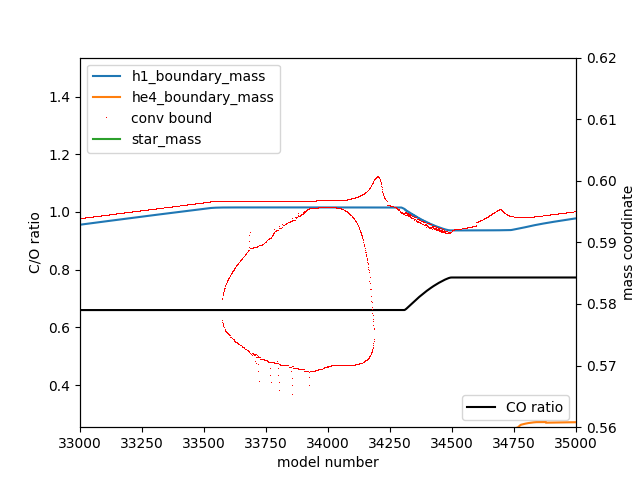

In [135]:
# create kippenhahn diagram
plt.figure(1)
star3.kippenhahn_CO(1,'model')

# set limits
plt.xlim([33000,35000])
plt.ylim([0.56,0.62])

# get xlims for thermal pulse convection zone analysis
model_range = plt.gca().get_xlim()
mass_range = plt.gca().get_ylim()

<IPython.core.display.Javascript object>


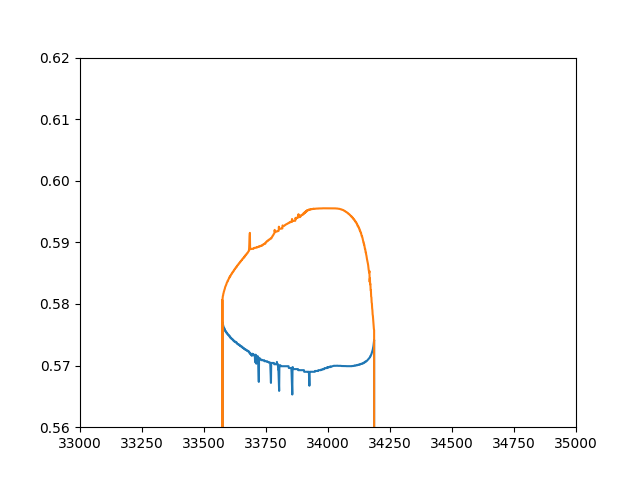

(0.56000000000000005, 0.62)

In [127]:
# check the mixing numbers to find characteristic thermal pulses in interior
mx1_bot = star3.get('mx2_bot')
mx1_top = star3.get('mx2_top')
model_number = star3.get('model_number')
star_mass = star3.get('star_mass')

plt.figure(2)
plt.plot(model_number,mx1_bot * star_mass)
plt.plot(model_number,mx1_top * star_mass)

# set limits
plt.xlim(model_range)
plt.ylim(mass_range)

In [128]:
# what values are mixing when there is no second convection zone?
mx1_thermal = mx1_bot[33000:35000]

print 'The values of mx1 before the convection zone average to', np.mean(mx1_thermal[0:500])
print 'The values of mx1 in the convection zone average to', np.mean(mx1_thermal[600:1000])

The values of mx1 before the convection zone average to 0.0
The values of mx1 in the convection zone average to 0.29898259902


The second mixing number gives the mass coordinates (and Schwarzschild) boundaries of the He-flash convection zone for the thermal pulse. This will be used to help with changing what the diffusion coefficient is. They are also exactly zero when there is no convection zone.

In [129]:
# get the convective velocities, mass, radius and time steps
time = star3.get('log_dt')
mass = star3_pp.se.get(model,'mass')
radius = star3_pp.se.get(model,'radius')
conv_velocity = star3_log.get('conv_vel_div_csound') * star3_log.get('csound')

# convert to absolute time in days
time = 10**(time) * 365.25

# convert to cm/s velocity
# conv_velocity = 10**(conv_velocity)

# find convection zone model numbers
thermal_pulse = []
for i in range(len(mx1_thermal)):
    
    # find first model to be nonzero
    if mx1_thermal[i] == 0 and mx1_thermal[i+1] > 0:
        thermal_pulse.append(i+1)
        break

# re loop until the end is found
for i in range(thermal_pulse[0]+20,len(mx1_thermal)):
    
    # find first model to be zero
    if mx1_thermal[i + thermal_pulse[0] + 20] == 0:
        thermal_pulse.append(i + thermal_pulse[0] + 20)
        break
        
# grab the average, std, min and max time step for the thermal pulse
offset = 33000

print ''
print 'The mean time step is', np.mean(time[(offset+thermal_pulse[0]):(offset+thermal_pulse[1])])
print 'The std of the time steps is', np.std(time[(offset+thermal_pulse[0]):(offset+thermal_pulse[1])])
print 'The min time step is', np.min(time[(offset+thermal_pulse[0]):(offset+thermal_pulse[1])])
print 'The max time step is', np.max(time[(offset+thermal_pulse[0]):(offset+thermal_pulse[1])])

 reading ['radius']...100%
The mean time step is 105.734499773
The std of the time steps is 245.872160171
The min time step is 1.18857624177
The max time step is 1986.61436695


<IPython.core.display.Javascript object>


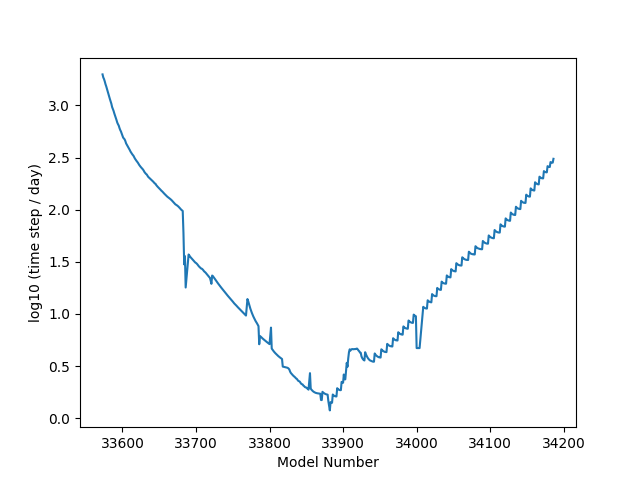

In [130]:
# plot as a function of model number
plt.figure(3)
plt.plot(model_number[(offset+thermal_pulse[0]):(offset+thermal_pulse[1])],
         np.log10(time[(offset+thermal_pulse[0]):(offset+thermal_pulse[1])]))

# labels
plt.xlabel('Model Number')
plt.ylabel('log10 (time step / day)')

# save figure
plt.savefig('Time Step Convection Zone.png')

<IPython.core.display.Javascript object>


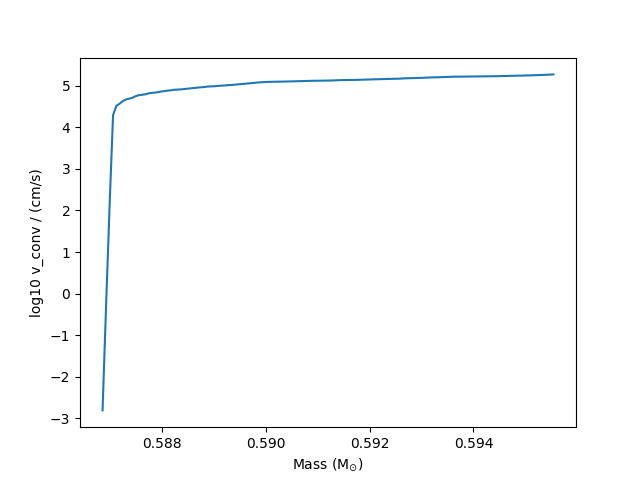

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


In [131]:
# plot the convective velocity as a function of radius (supposedly cm/s)
plt.figure(4)
plt.plot(mass[convection_index[0]:convection_index[1]],
         np.log10(conv_velocity[convection_index[0]:convection_index[1]]))

# labels
plt.xlabel('Mass (M$_{\odot}$)')
plt.ylabel('log10 v_conv / (cm/s)')

In [132]:
# find the extent in radius of the convection zone
convection_mass = [mx1_bot[model - 1] * star_mass[model-1],mx1_top[model - 1] * star_mass[model-1]]
convection_index = [np.argmin(abs(convection_mass[0] - mass)),np.argmin(abs(convection_mass[1] - mass))]

# get the radial extent of this convection zone in cm
Rsun = 6.957e8 * 100.
convection_radius = (radius[convection_index[1]] - radius[convection_index[0]]) * Rsun

# get the convective time scale, average convective velocities
avg_velocity = np.mean(conv_velocity[(convection_index[0]+20):convection_index[1]])

print 'The average convective velocity is', avg_velocity

# average time in days
conv_time = (2 * convection_radius / avg_velocity ) / (60.*60.*24.)

print 'The average convective time scale is', conv_time, 'days'

# determine the sub-time step (at least 4 time steps)
print 'The number of time steps required to resolve convection is', time[model -1] / (conv_time / 4.)

The average convective velocity is 30388.9743743
The average convective time scale is 1.83516467863 days
The number of time steps required to resolve convection is 10.2597127998


In [133]:
np.mean(conv_velocity[convection_index[0]:convection_index[1]]) / (1000. * 100.)

0.29346470965232896

In [113]:
radius * Rsun

array([  3.17034117e+06,   3.93535202e+06,   4.95836465e+06, ...,
         2.33957771e+13,   2.33957771e+13,   2.33957771e+13])